In [1]:
# %load runSA1SA2.py
import ggcnn.experiment as experiment
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold


def load_sa1_dataset():
    keys_SA1 = []
    features_SA1 = []
    labels = []
    keys_SA2 = []
    features_SA2 = []
    
    # Load SA1 Node Features
    with open('Data/2018-08-24-NSW-SA1Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA1.append(s[0])
            features_SA1.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y
#             labels.append(np.floor(float(s[-1]) / 10).astype(int))
            labels.append(float(s[-1]))
    
    
    # Load SA2 Node Features
    with open('Data/2018-08-28-NSW-SA2Input-Normalised.csv', 'r') as file:
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')  # Last value in line is \n
            keys_SA2.append(s[0])
            features_SA2.extend([float(v) for v in s[1:-1]])  # Last column is the outcome y

    labels = np.array(labels)
    features_SA1 = np.array(features_SA1).reshape((len(keys_SA1), -1))
    features_SA2 = np.array(features_SA2).reshape((len(keys_SA2), -1))
    
    # Load SA1 Link Features
    with open('Data/2018-08-25-NSW-NeighbourDistance.csv', 'r') as file:
        adj_mat_SA1 = np.zeros((len(keys_SA1), len(keys_SA1)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA1.index(s[1])
            adj_mat_SA1[a, b] = 1
            adj_mat_SA1[b, a] = 1
    

    # Load SA2 Link Features
    with open('Data/Geography/2018-08-28-NSW-SA2_Neighbouring_Suburbs_With_Bridges-GCC.csv', 'r') as file:
        adj_mat_SA2 = np.zeros((len(keys_SA2), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA2.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA2[a, b] = 1
            adj_mat_SA2[b, a] = 1
    
    
    # Load SA1, SA2 Links
    with open('Data/SA1SA2Links.csv', 'r') as file:
        adj_mat_SA1SA2 = np.zeros((len(keys_SA1), len(keys_SA2)))
        for i, line in enumerate(file):
            if i == 0:  # Skip first line (header)
                continue
            s = line[:-1].split(',')
            a = keys_SA1.index(s[0])
            b = keys_SA2.index(s[1])
            adj_mat_SA1SA2[a, b] = 1
    
    adj_mat_SA2SA1 = np.transpose(adj_mat_SA1SA2)
    
#     adj_mat_SA1SA2 = adj_mat_SA1SA2 / np.sum(adj_mat_SA1SA2, axis = -1, keepdims = True)
#     adj_mat_SA2SA1 = adj_mat_SA2SA1 / np.sum(adj_mat_SA2SA1, axis = -1, keepdims = True)
    
    return features_SA1, adj_mat_SA1, labels, features_SA2, adj_mat_SA2, adj_mat_SA1SA2, adj_mat_SA2SA1

dataset = load_sa1_dataset()

/home/paperspace/anaconda3/envs/tf-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/tf-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
class SA1Experiment():
    def __init__(self, neurons, blocks):
        self.blocks = blocks
        self.neurons = neurons
    
    def create_network(self, net, input):
        net.create_network(input)
        net.make_embedding_layer(self.neurons)
        net.make_dropout_layer()
        
        for _ in range(self.blocks):
            net.make_graphcnn_layer(self.neurons)
            net.make_dropout_layer()
            net.make_embedding_layer(self.neurons)
            net.make_dropout_layer()
        
        net.make_auxilary_embedding_layer(self.neurons)
        net.make_auxilary_dropout_layer()
#         net.make_reverse_auxilary_linkage_layer(self.neurons)
# #         net.make_auxilary_embedding_layer(self.neurons)
# #         net.make_auxilary_dropout_layer()
#         net.make_auxilary_graphcnn_layer(self.neurons)
#         net.make_auxilary_dropout_layer()
        net.make_auxilary_linkage_layer(0)
        
        net.make_embedding_layer(self.neurons)
        net.make_embedding_layer(1, name='final', with_bn=False, with_act_func = False)


no_folds = 10
inst = KFold(n_splits = no_folds, shuffle=True, random_state=125)

l = 2
n = 128
i = 4

    
exp = experiment.GGCNNExperiment('2018-08-28-SA1SA2', '2018-08-28-SA1SA2', SA1Experiment(neurons = n, blocks = l))


exp.num_iterations = 5000
exp.optimizer = 'adam'
exp.loss_type = 'linear'

exp.debug = True  # Was True

exp.preprocess_data(dataset)

# train_idx, test_idx = list(inst.split(np.arange(len(dataset[0]))))[i]
test_idx, train_idx = list(inst.split(np.arange(len(dataset[0]))))[i]  # Reversed to get more samples in the test set than the training set


exp.create_data(train_idx, test_idx)
exp.build_network()
results = exp.run()

2018-08-29 09:16:20.789898 Creating training Tensorflow Tensors
2018-08-29 09:16:20.790790 Creating training network
2018-08-29 09:16:21.870937 Creating loss function and summaries
2018-08-29 09:16:21.926543 Training model "2018-08-28-SA1SA2"!
2018-08-29 09:16:21.926671 Preparing training
2018-08-29 09:16:24.574191 Starting threads
2018-08-29 09:16:24.574452 Starting training. train_batch_size: 0 test_batch_size: 0
2018-08-29 09:16:25.166567 Test Step 0 Finished
2018-08-29 09:16:25.166704 Test Step 0 "min loss" =  1.1789432e+21
2018-08-29 09:16:25.166772 Test Step 0 "loss" =  1.1789432e+21
2018-08-29 09:16:26.999297 Training Step 0 Finished Timing (Training: 0.756021, Test: 0.24385) after 2.42376 seconds
2018-08-29 09:16:26.999429 Training Step 0 "min loss" =  2893.8071
2018-08-29 09:16:26.999494 Training Step 0 "loss" =  2893.8071
2018-08-29 09:16:27.201145 Test Step 5 Finished
2018-08-29 09:16:27.201808 Test Step 5 "min loss" =  2778.2944
2018-08-29 09:16:27.201905 Test Step 5 "loss"

2018-08-29 09:16:31.689869 Test Step 95 Finished
2018-08-29 09:16:31.689998 Test Step 95 "min loss" =  1984.066
2018-08-29 09:16:31.690061 Test Step 95 "loss" =  1984.066
2018-08-29 09:16:31.735880 Training Step 95 Finished Timing (Training: 0.90745, Test: 0.0848156) after 0.247328 seconds
2018-08-29 09:16:31.736015 Training Step 95 "min loss" =  2025.1403
2018-08-29 09:16:31.736080 Training Step 95 "loss" =  2025.1403
2018-08-29 09:16:31.938559 Test Step 100 Finished
2018-08-29 09:16:31.938687 Test Step 100 "min loss" =  1934.6302
2018-08-29 09:16:31.939289 Test Step 100 "loss" =  1934.6302
2018-08-29 09:16:31.984918 Training Step 100 Finished Timing (Training: 0.907475, Test: 0.0847074) after 0.24786 seconds
2018-08-29 09:16:31.985044 Training Step 100 "min loss" =  1980.3411
2018-08-29 09:16:31.985110 Training Step 100 "loss" =  1980.3411
2018-08-29 09:16:32.185614 Test Step 105 Finished
2018-08-29 09:16:32.186300 Test Step 105 "min loss" =  1887.2228
2018-08-29 09:16:32.186378 Test

2018-08-29 09:16:36.670704 Test Step 195 Finished
2018-08-29 09:16:36.670836 Test Step 195 "min loss" =  1098.4591
2018-08-29 09:16:36.671394 Test Step 195 "loss" =  1098.4591
2018-08-29 09:16:36.717044 Training Step 195 Finished Timing (Training: 0.909449, Test: 0.0840952) after 0.248596 seconds
2018-08-29 09:16:36.717217 Training Step 195 "min loss" =  1143.2319
2018-08-29 09:16:36.717284 Training Step 195 "loss" =  1143.2319
2018-08-29 09:16:36.920660 Test Step 200 Finished
2018-08-29 09:16:36.920838 Test Step 200 "min loss" =  1057.8809
2018-08-29 09:16:36.920914 Test Step 200 "loss" =  1057.8809
2018-08-29 09:16:36.967168 Training Step 200 Finished Timing (Training: 0.909452, Test: 0.0840644) after 0.249796 seconds
2018-08-29 09:16:36.967309 Training Step 200 "min loss" =  1099.8684
2018-08-29 09:16:36.967412 Training Step 200 "loss" =  1099.8684
2018-08-29 09:16:37.169294 Test Step 205 Finished
2018-08-29 09:16:37.169427 Test Step 205 "min loss" =  1012.44995
2018-08-29 09:16:37.

2018-08-29 09:16:41.661695 Test Step 295 Finished
2018-08-29 09:16:41.661838 Test Step 295 "min loss" =  414.45932
2018-08-29 09:16:41.661906 Test Step 295 "loss" =  414.45932
2018-08-29 09:16:41.708269 Training Step 295 Finished Timing (Training: 0.909599, Test: 0.0835895) after 0.248873 seconds
2018-08-29 09:16:41.708422 Training Step 295 "min loss" =  433.96906
2018-08-29 09:16:41.709117 Training Step 295 "loss" =  433.96906
2018-08-29 09:16:41.910802 Test Step 300 Finished
2018-08-29 09:16:41.911289 Test Step 300 "min loss" =  393.45267
2018-08-29 09:16:41.911534 Test Step 300 "loss" =  393.45267
2018-08-29 09:16:41.957143 Training Step 300 Finished Timing (Training: 0.909585, Test: 0.0834993) after 0.247939 seconds
2018-08-29 09:16:41.957289 Training Step 300 "min loss" =  409.7918
2018-08-29 09:16:41.958041 Training Step 300 "loss" =  409.7918
2018-08-29 09:16:42.159896 Test Step 305 Finished
2018-08-29 09:16:42.160047 Test Step 305 "min loss" =  353.26785
2018-08-29 09:16:42.160

2018-08-29 09:16:46.629697 Test Step 395 Finished
2018-08-29 09:16:46.629894 Test Step 395 "min loss" =  102.331085
2018-08-29 09:16:46.630465 Test Step 395 "loss" =  102.331085
2018-08-29 09:16:46.675683 Training Step 395 Finished Timing (Training: 0.908534, Test: 0.0836306) after 0.246719 seconds
2018-08-29 09:16:46.675812 Training Step 395 "min loss" =  102.65161
2018-08-29 09:16:46.675868 Training Step 395 "loss" =  102.65161
2018-08-29 09:16:46.877706 Test Step 400 Finished
2018-08-29 09:16:46.877847 Test Step 400 "min loss" =  96.018456
2018-08-29 09:16:46.878669 Test Step 400 "loss" =  96.018456
2018-08-29 09:16:46.923712 Training Step 400 Finished Timing (Training: 0.908527, Test: 0.0835651) after 0.246805 seconds
2018-08-29 09:16:46.923881 Training Step 400 "min loss" =  94.54978
2018-08-29 09:16:46.924518 Training Step 400 "loss" =  94.54978
2018-08-29 09:16:47.125288 Test Step 405 Finished
2018-08-29 09:16:47.125890 Test Step 405 "min loss" =  94.55837
2018-08-29 09:16:47.12

2018-08-29 09:16:51.579557 Test Step 495 Finished
2018-08-29 09:16:51.579795 Test Step 495 "min loss" =  33.98298
2018-08-29 09:16:51.579919 Test Step 495 "loss" =  35.405598
2018-08-29 09:16:51.625106 Training Step 495 Finished Timing (Training: 0.909354, Test: 0.0839116) after 0.24702 seconds
2018-08-29 09:16:51.625253 Training Step 495 "min loss" =  20.47143
2018-08-29 09:16:51.625980 Training Step 495 "loss" =  20.47143
2018-08-29 09:16:51.827139 Test Step 500 Finished
2018-08-29 09:16:51.827277 Test Step 500 "min loss" =  31.702091
2018-08-29 09:16:51.827346 Test Step 500 "loss" =  31.702091
2018-08-29 09:16:51.872958 Training Step 500 Finished Timing (Training: 0.909147, Test: 0.0839398) after 0.246512 seconds
2018-08-29 09:16:51.873081 Training Step 500 "min loss" =  18.734343
2018-08-29 09:16:51.873698 Training Step 500 "loss" =  18.734343
2018-08-29 09:16:52.074290 Test Step 505 Finished
2018-08-29 09:16:52.074871 Test Step 505 "min loss" =  29.495544
2018-08-29 09:16:52.07512

2018-08-29 09:16:56.529097 Test Step 595 Finished
2018-08-29 09:16:56.529252 Test Step 595 "min loss" =  21.824427
2018-08-29 09:16:56.529328 Test Step 595 "loss" =  22.238285
2018-08-29 09:16:56.574192 Training Step 595 Finished Timing (Training: 0.909674, Test: 0.0839032) after 0.245377 seconds
2018-08-29 09:16:56.574337 Training Step 595 "min loss" =  9.547675
2018-08-29 09:16:56.574405 Training Step 595 "loss" =  10.2899685
2018-08-29 09:16:56.774391 Test Step 600 Finished
2018-08-29 09:16:56.774540 Test Step 600 "min loss" =  21.824427
2018-08-29 09:16:56.774600 Test Step 600 "loss" =  22.279734
2018-08-29 09:16:56.820882 Training Step 600 Finished Timing (Training: 0.909709, Test: 0.0839082) after 0.246395 seconds
2018-08-29 09:16:56.821025 Training Step 600 "min loss" =  9.547675
2018-08-29 09:16:56.821106 Training Step 600 "loss" =  12.272292
2018-08-29 09:16:57.022865 Test Step 605 Finished
2018-08-29 09:16:57.023016 Test Step 605 "min loss" =  21.824427
2018-08-29 09:16:57.02

2018-08-29 09:17:01.485910 Test Step 695 Finished
2018-08-29 09:17:01.486075 Test Step 695 "min loss" =  20.247643
2018-08-29 09:17:01.487189 Test Step 695 "loss" =  21.225367
2018-08-29 09:17:01.532529 Training Step 695 Finished Timing (Training: 0.908808, Test: 0.0838623) after 0.248448 seconds
2018-08-29 09:17:01.533078 Training Step 695 "min loss" =  7.616792
2018-08-29 09:17:01.533208 Training Step 695 "loss" =  8.987994
2018-08-29 09:17:01.736647 Test Step 700 Finished
2018-08-29 09:17:01.736871 Test Step 700 "min loss" =  20.163656
2018-08-29 09:17:01.737005 Test Step 700 "loss" =  20.163656
2018-08-29 09:17:01.782330 Training Step 700 Finished Timing (Training: 0.908724, Test: 0.0838604) after 0.248134 seconds
2018-08-29 09:17:01.782477 Training Step 700 "min loss" =  7.616792
2018-08-29 09:17:01.782537 Training Step 700 "loss" =  8.671356
2018-08-29 09:17:01.984334 Test Step 705 Finished
2018-08-29 09:17:01.984512 Test Step 705 "min loss" =  18.946516
2018-08-29 09:17:01.98458

2018-08-29 09:17:06.443829 Test Step 795 Finished
2018-08-29 09:17:06.444049 Test Step 795 "min loss" =  18.946516
2018-08-29 09:17:06.444603 Test Step 795 "loss" =  20.552835
2018-08-29 09:17:06.490525 Training Step 795 Finished Timing (Training: 0.90879, Test: 0.0836096) after 0.247279 seconds
2018-08-29 09:17:06.490674 Training Step 795 "min loss" =  7.258106
2018-08-29 09:17:06.491203 Training Step 795 "loss" =  7.838952
2018-08-29 09:17:06.692490 Test Step 800 Finished
2018-08-29 09:17:06.693294 Test Step 800 "min loss" =  18.946516
2018-08-29 09:17:06.693365 Test Step 800 "loss" =  22.325119
2018-08-29 09:17:06.738267 Training Step 800 Finished Timing (Training: 0.908717, Test: 0.0836221) after 0.246559 seconds
2018-08-29 09:17:06.738406 Training Step 800 "min loss" =  7.258106
2018-08-29 09:17:06.739096 Training Step 800 "loss" =  7.710704
2018-08-29 09:17:06.939666 Test Step 805 Finished
2018-08-29 09:17:06.939801 Test Step 805 "min loss" =  18.946516
2018-08-29 09:17:06.940650

2018-08-29 09:17:11.401592 Test Step 895 Finished
2018-08-29 09:17:11.401734 Test Step 895 "min loss" =  18.946516
2018-08-29 09:17:11.402318 Test Step 895 "loss" =  20.728243
2018-08-29 09:17:11.448277 Training Step 895 Finished Timing (Training: 0.909177, Test: 0.0836111) after 0.247153 seconds
2018-08-29 09:17:11.448406 Training Step 895 "min loss" =  6.227859
2018-08-29 09:17:11.448468 Training Step 895 "loss" =  6.227859
2018-08-29 09:17:11.647778 Test Step 900 Finished
2018-08-29 09:17:11.647920 Test Step 900 "min loss" =  18.946516
2018-08-29 09:17:11.647967 Test Step 900 "loss" =  20.307777
2018-08-29 09:17:11.692958 Training Step 900 Finished Timing (Training: 0.90942, Test: 0.0836131) after 0.244408 seconds
2018-08-29 09:17:11.693108 Training Step 900 "min loss" =  6.227859
2018-08-29 09:17:11.693856 Training Step 900 "loss" =  7.4922013
2018-08-29 09:17:11.894192 Test Step 905 Finished
2018-08-29 09:17:11.894362 Test Step 905 "min loss" =  18.946516
2018-08-29 09:17:11.89443

2018-08-29 09:17:16.359875 Test Step 995 Finished
2018-08-29 09:17:16.360022 Test Step 995 "min loss" =  18.743021
2018-08-29 09:17:16.360092 Test Step 995 "loss" =  18.951494
2018-08-29 09:17:16.406604 Training Step 995 Finished Timing (Training: 0.908419, Test: 0.0838223) after 0.247811 seconds
2018-08-29 09:17:16.406750 Training Step 995 "min loss" =  5.908632
2018-08-29 09:17:16.407474 Training Step 995 "loss" =  7.174879
2018-08-29 09:17:16.608503 Test Step 1000 Finished
2018-08-29 09:17:16.608668 Test Step 1000 "min loss" =  18.743021
2018-08-29 09:17:16.609267 Test Step 1000 "loss" =  19.574663
2018-08-29 09:17:16.655132 Training Step 1000 Finished Timing (Training: 0.908375, Test: 0.0837944) after 0.247131 seconds
2018-08-29 09:17:16.655286 Training Step 1000 "min loss" =  5.908632
2018-08-29 09:17:16.656190 Training Step 1000 "loss" =  6.5866575
2018-08-29 09:17:16.857086 Test Step 1005 Finished
2018-08-29 09:17:16.857237 Test Step 1005 "min loss" =  18.743021
2018-08-29 09:17

2018-08-29 09:17:21.069940 Test Step 1090 Finished
2018-08-29 09:17:21.070101 Test Step 1090 "min loss" =  17.800083
2018-08-29 09:17:21.070745 Test Step 1090 "loss" =  19.363619
2018-08-29 09:17:21.115686 Training Step 1090 Finished Timing (Training: 0.908679, Test: 0.0835044) after 0.24574 seconds
2018-08-29 09:17:21.116283 Training Step 1090 "min loss" =  5.4693847
2018-08-29 09:17:21.116711 Training Step 1090 "loss" =  6.264105
2018-08-29 09:17:21.317325 Test Step 1095 Finished
2018-08-29 09:17:21.317502 Test Step 1095 "min loss" =  17.800083
2018-08-29 09:17:21.317570 Test Step 1095 "loss" =  19.134089
2018-08-29 09:17:21.363859 Training Step 1095 Finished Timing (Training: 0.908518, Test: 0.083456) after 0.246692 seconds
2018-08-29 09:17:21.364000 Training Step 1095 "min loss" =  5.4693847
2018-08-29 09:17:21.364065 Training Step 1095 "loss" =  5.617114
2018-08-29 09:17:21.564438 Test Step 1100 Finished
2018-08-29 09:17:21.565004 Test Step 1100 "min loss" =  17.800083
2018-08-29 

2018-08-29 09:17:25.778645 Test Step 1185 Finished
2018-08-29 09:17:25.779327 Test Step 1185 "min loss" =  17.700176
2018-08-29 09:17:25.779727 Test Step 1185 "loss" =  17.872036
2018-08-29 09:17:25.825245 Training Step 1185 Finished Timing (Training: 0.908909, Test: 0.0835998) after 0.246967 seconds
2018-08-29 09:17:25.825379 Training Step 1185 "min loss" =  5.2685084
2018-08-29 09:17:25.825447 Training Step 1185 "loss" =  5.8589215
2018-08-29 09:17:26.026640 Test Step 1190 Finished
2018-08-29 09:17:26.026798 Test Step 1190 "min loss" =  17.700176
2018-08-29 09:17:26.027331 Test Step 1190 "loss" =  18.32497
2018-08-29 09:17:26.072330 Training Step 1190 Finished Timing (Training: 0.909006, Test: 0.0836696) after 0.246794 seconds
2018-08-29 09:17:26.072477 Training Step 1190 "min loss" =  5.2685084
2018-08-29 09:17:26.072554 Training Step 1190 "loss" =  5.4683857
2018-08-29 09:17:26.273432 Test Step 1195 Finished
2018-08-29 09:17:26.273598 Test Step 1195 "min loss" =  17.700176
2018-08-

2018-08-29 09:17:30.490479 Test Step 1280 Finished
2018-08-29 09:17:30.490631 Test Step 1280 "min loss" =  17.686457
2018-08-29 09:17:30.491380 Test Step 1280 "loss" =  17.93677
2018-08-29 09:17:30.536762 Training Step 1280 Finished Timing (Training: 0.909046, Test: 0.0835046) after 0.2462 seconds
2018-08-29 09:17:30.536904 Training Step 1280 "min loss" =  4.9162765
2018-08-29 09:17:30.537587 Training Step 1280 "loss" =  5.3593383
2018-08-29 09:17:30.738993 Test Step 1285 Finished
2018-08-29 09:17:30.739126 Test Step 1285 "min loss" =  17.686457
2018-08-29 09:17:30.739246 Test Step 1285 "loss" =  18.679148
2018-08-29 09:17:30.785693 Training Step 1285 Finished Timing (Training: 0.909177, Test: 0.083501) after 0.247999 seconds
2018-08-29 09:17:30.785837 Training Step 1285 "min loss" =  4.7840314
2018-08-29 09:17:30.786364 Training Step 1285 "loss" =  5.044713
2018-08-29 09:17:30.986810 Test Step 1290 Finished
2018-08-29 09:17:30.987523 Test Step 1290 "min loss" =  17.686457
2018-08-29 0

2018-08-29 09:17:35.198624 Test Step 1375 Finished
2018-08-29 09:17:35.198845 Test Step 1375 "min loss" =  17.686457
2018-08-29 09:17:35.198967 Test Step 1375 "loss" =  18.389374
2018-08-29 09:17:35.245043 Training Step 1375 Finished Timing (Training: 0.909267, Test: 0.0833221) after 0.246943 seconds
2018-08-29 09:17:35.245215 Training Step 1375 "min loss" =  4.6561127
2018-08-29 09:17:35.245334 Training Step 1375 "loss" =  4.9599857
2018-08-29 09:17:35.446286 Test Step 1380 Finished
2018-08-29 09:17:35.446434 Test Step 1380 "min loss" =  17.686457
2018-08-29 09:17:35.446517 Test Step 1380 "loss" =  18.133743
2018-08-29 09:17:35.492087 Training Step 1380 Finished Timing (Training: 0.909357, Test: 0.0833029) after 0.246622 seconds
2018-08-29 09:17:35.492245 Training Step 1380 "min loss" =  4.6561127
2018-08-29 09:17:35.492314 Training Step 1380 "loss" =  5.0700865
2018-08-29 09:17:35.692703 Test Step 1385 Finished
2018-08-29 09:17:35.692849 Test Step 1385 "min loss" =  17.686457
2018-08

2018-08-29 09:17:39.909898 Test Step 1470 Finished
2018-08-29 09:17:39.910359 Test Step 1470 "min loss" =  17.59922
2018-08-29 09:17:39.910425 Test Step 1470 "loss" =  18.219881
2018-08-29 09:17:39.955756 Training Step 1470 Finished Timing (Training: 0.908463, Test: 0.0838746) after 0.245975 seconds
2018-08-29 09:17:39.955889 Training Step 1470 "min loss" =  4.4662237
2018-08-29 09:17:39.955955 Training Step 1470 "loss" =  4.7035623
2018-08-29 09:17:40.157464 Test Step 1475 Finished
2018-08-29 09:17:40.157650 Test Step 1475 "min loss" =  17.582926
2018-08-29 09:17:40.157724 Test Step 1475 "loss" =  17.582926
2018-08-29 09:17:40.202970 Training Step 1475 Finished Timing (Training: 0.908466, Test: 0.0839505) after 0.246002 seconds
2018-08-29 09:17:40.203104 Training Step 1475 "min loss" =  4.4662237
2018-08-29 09:17:40.203797 Training Step 1475 "loss" =  4.8456187
2018-08-29 09:17:40.405096 Test Step 1480 Finished
2018-08-29 09:17:40.405229 Test Step 1480 "min loss" =  17.582926
2018-08-

2018-08-29 09:17:44.622749 Test Step 1565 Finished
2018-08-29 09:17:44.623440 Test Step 1565 "min loss" =  17.582926
2018-08-29 09:17:44.623740 Test Step 1565 "loss" =  18.615833
2018-08-29 09:17:44.668984 Training Step 1565 Finished Timing (Training: 0.908647, Test: 0.0837277) after 0.247375 seconds
2018-08-29 09:17:44.669134 Training Step 1565 "min loss" =  4.230915
2018-08-29 09:17:44.669844 Training Step 1565 "loss" =  5.100621
2018-08-29 09:17:44.870134 Test Step 1570 Finished
2018-08-29 09:17:44.870286 Test Step 1570 "min loss" =  17.582926
2018-08-29 09:17:44.870351 Test Step 1570 "loss" =  18.806505
2018-08-29 09:17:44.915155 Training Step 1570 Finished Timing (Training: 0.90884, Test: 0.0837039) after 0.24522 seconds
2018-08-29 09:17:44.915298 Training Step 1570 "min loss" =  4.230915
2018-08-29 09:17:44.916291 Training Step 1570 "loss" =  5.062074
2018-08-29 09:17:45.117021 Test Step 1575 Finished
2018-08-29 09:17:45.117181 Test Step 1575 "min loss" =  17.582926
2018-08-29 09

2018-08-29 09:17:49.323494 Test Step 1660 Finished
2018-08-29 09:17:49.323650 Test Step 1660 "min loss" =  17.49152
2018-08-29 09:17:49.323721 Test Step 1660 "loss" =  19.792217
2018-08-29 09:17:49.368707 Training Step 1660 Finished Timing (Training: 0.91054, Test: 0.0837249) after 0.246213 seconds
2018-08-29 09:17:49.368835 Training Step 1660 "min loss" =  3.970532
2018-08-29 09:17:49.368900 Training Step 1660 "loss" =  4.6729093
2018-08-29 09:17:49.568572 Test Step 1665 Finished
2018-08-29 09:17:49.569242 Test Step 1665 "min loss" =  17.49152
2018-08-29 09:17:49.569508 Test Step 1665 "loss" =  18.703129
2018-08-29 09:17:49.615651 Training Step 1665 Finished Timing (Training: 0.910478, Test: 0.0836861) after 0.246659 seconds
2018-08-29 09:17:49.615827 Training Step 1665 "min loss" =  3.970532
2018-08-29 09:17:49.615949 Training Step 1665 "loss" =  4.816938
2018-08-29 09:17:49.817833 Test Step 1670 Finished
2018-08-29 09:17:49.818488 Test Step 1670 "min loss" =  17.49152
2018-08-29 09:

2018-08-29 09:17:54.029485 Test Step 1755 Finished
2018-08-29 09:17:54.029633 Test Step 1755 "min loss" =  17.317165
2018-08-29 09:17:54.029694 Test Step 1755 "loss" =  18.943209
2018-08-29 09:17:54.075782 Training Step 1755 Finished Timing (Training: 0.908723, Test: 0.0836676) after 0.247213 seconds
2018-08-29 09:17:54.075925 Training Step 1755 "min loss" =  3.8544781
2018-08-29 09:17:54.076516 Training Step 1755 "loss" =  4.307262
2018-08-29 09:17:54.276948 Test Step 1760 Finished
2018-08-29 09:17:54.277083 Test Step 1760 "min loss" =  17.317165
2018-08-29 09:17:54.277826 Test Step 1760 "loss" =  17.985615
2018-08-29 09:17:54.323164 Training Step 1760 Finished Timing (Training: 0.908711, Test: 0.0835654) after 0.246565 seconds
2018-08-29 09:17:54.323319 Training Step 1760 "min loss" =  3.8544781
2018-08-29 09:17:54.324125 Training Step 1760 "loss" =  4.7087693
2018-08-29 09:17:54.524350 Test Step 1765 Finished
2018-08-29 09:17:54.524971 Test Step 1765 "min loss" =  17.317165
2018-08-

2018-08-29 09:17:58.736639 Test Step 1850 Finished
2018-08-29 09:17:58.736782 Test Step 1850 "min loss" =  17.317165
2018-08-29 09:17:58.736858 Test Step 1850 "loss" =  18.629341
2018-08-29 09:17:58.782323 Training Step 1850 Finished Timing (Training: 0.908237, Test: 0.0837157) after 0.246026 seconds
2018-08-29 09:17:58.782443 Training Step 1850 "min loss" =  3.7255967
2018-08-29 09:17:58.782525 Training Step 1850 "loss" =  4.1938553
2018-08-29 09:17:58.984024 Test Step 1855 Finished
2018-08-29 09:17:58.984164 Test Step 1855 "min loss" =  16.456541
2018-08-29 09:17:58.984233 Test Step 1855 "loss" =  16.456541
2018-08-29 09:17:59.030168 Training Step 1855 Finished Timing (Training: 0.90867, Test: 0.0837907) after 0.247555 seconds
2018-08-29 09:17:59.030308 Training Step 1855 "min loss" =  3.7255967
2018-08-29 09:17:59.031128 Training Step 1855 "loss" =  4.0074034
2018-08-29 09:17:59.231695 Test Step 1860 Finished
2018-08-29 09:17:59.231832 Test Step 1860 "min loss" =  16.456541
2018-08-

2018-08-29 09:18:03.446069 Test Step 1945 Finished
2018-08-29 09:18:03.446206 Test Step 1945 "min loss" =  16.456541
2018-08-29 09:18:03.446902 Test Step 1945 "loss" =  18.335808
2018-08-29 09:18:03.491903 Training Step 1945 Finished Timing (Training: 0.909997, Test: 0.0826236) after 0.245225 seconds
2018-08-29 09:18:03.492021 Training Step 1945 "min loss" =  3.7161436
2018-08-29 09:18:03.492075 Training Step 1945 "loss" =  4.303908
2018-08-29 09:18:03.694518 Test Step 1950 Finished
2018-08-29 09:18:03.695076 Test Step 1950 "min loss" =  16.456541
2018-08-29 09:18:03.695255 Test Step 1950 "loss" =  17.432417
2018-08-29 09:18:03.740932 Training Step 1950 Finished Timing (Training: 0.909637, Test: 0.0829047) after 0.247932 seconds
2018-08-29 09:18:03.741067 Training Step 1950 "min loss" =  3.5346596
2018-08-29 09:18:03.741136 Training Step 1950 "loss" =  3.960867
2018-08-29 09:18:03.941927 Test Step 1955 Finished
2018-08-29 09:18:03.942068 Test Step 1955 "min loss" =  16.456541
2018-08-2

2018-08-29 09:18:08.164780 Test Step 2040 Finished
2018-08-29 09:18:08.164940 Test Step 2040 "min loss" =  16.282578
2018-08-29 09:18:08.166051 Test Step 2040 "loss" =  16.932407
2018-08-29 09:18:08.211953 Training Step 2040 Finished Timing (Training: 0.90735, Test: 0.0838154) after 0.248046 seconds
2018-08-29 09:18:08.212584 Training Step 2040 "min loss" =  3.5133085
2018-08-29 09:18:08.212648 Training Step 2040 "loss" =  4.0306573
2018-08-29 09:18:08.414089 Test Step 2045 Finished
2018-08-29 09:18:08.414669 Test Step 2045 "min loss" =  16.282578
2018-08-29 09:18:08.415059 Test Step 2045 "loss" =  16.785484
2018-08-29 09:18:08.460236 Training Step 2045 Finished Timing (Training: 0.907523, Test: 0.0837739) after 0.24749 seconds
2018-08-29 09:18:08.460370 Training Step 2045 "min loss" =  3.5133085
2018-08-29 09:18:08.460880 Training Step 2045 "loss" =  4.2619505
2018-08-29 09:18:08.662109 Test Step 2050 Finished
2018-08-29 09:18:08.662243 Test Step 2050 "min loss" =  16.126656
2018-08-2

2018-08-29 09:18:12.875390 Test Step 2135 Finished
2018-08-29 09:18:12.875889 Test Step 2135 "min loss" =  16.126656
2018-08-29 09:18:12.876109 Test Step 2135 "loss" =  17.122423
2018-08-29 09:18:12.921472 Training Step 2135 Finished Timing (Training: 0.910087, Test: 0.0832548) after 0.246892 seconds
2018-08-29 09:18:12.921619 Training Step 2135 "min loss" =  3.271017
2018-08-29 09:18:12.921686 Training Step 2135 "loss" =  4.0473223
2018-08-29 09:18:13.123732 Test Step 2140 Finished
2018-08-29 09:18:13.123862 Test Step 2140 "min loss" =  16.126656
2018-08-29 09:18:13.123922 Test Step 2140 "loss" =  17.74731
2018-08-29 09:18:13.170672 Training Step 2140 Finished Timing (Training: 0.910741, Test: 0.0831233) after 0.248887 seconds
2018-08-29 09:18:13.170802 Training Step 2140 "min loss" =  3.271017
2018-08-29 09:18:13.171537 Training Step 2140 "loss" =  4.0654106
2018-08-29 09:18:13.373019 Test Step 2145 Finished
2018-08-29 09:18:13.373235 Test Step 2145 "min loss" =  16.126656
2018-08-29

2018-08-29 09:18:17.590926 Test Step 2230 Finished
2018-08-29 09:18:17.591081 Test Step 2230 "min loss" =  15.324853
2018-08-29 09:18:17.591133 Test Step 2230 "loss" =  16.009153
2018-08-29 09:18:17.636370 Training Step 2230 Finished Timing (Training: 0.91012, Test: 0.0837308) after 0.246517 seconds
2018-08-29 09:18:17.636496 Training Step 2230 "min loss" =  3.2240639
2018-08-29 09:18:17.636547 Training Step 2230 "loss" =  4.168446
2018-08-29 09:18:17.838205 Test Step 2235 Finished
2018-08-29 09:18:17.838348 Test Step 2235 "min loss" =  15.324853
2018-08-29 09:18:17.838398 Test Step 2235 "loss" =  16.508394
2018-08-29 09:18:17.883576 Training Step 2235 Finished Timing (Training: 0.91028, Test: 0.0841359) after 0.246957 seconds
2018-08-29 09:18:17.883717 Training Step 2235 "min loss" =  3.2240639
2018-08-29 09:18:17.883765 Training Step 2235 "loss" =  3.599259
2018-08-29 09:18:18.084947 Test Step 2240 Finished
2018-08-29 09:18:18.085079 Test Step 2240 "min loss" =  15.324853
2018-08-29 

2018-08-29 09:18:22.312770 Test Step 2325 Finished
2018-08-29 09:18:22.312927 Test Step 2325 "min loss" =  15.324853
2018-08-29 09:18:22.312999 Test Step 2325 "loss" =  16.346071
2018-08-29 09:18:22.359270 Training Step 2325 Finished Timing (Training: 0.909985, Test: 0.0835817) after 0.2491 seconds
2018-08-29 09:18:22.359421 Training Step 2325 "min loss" =  3.2240639
2018-08-29 09:18:22.359492 Training Step 2325 "loss" =  3.6693504
2018-08-29 09:18:22.562072 Test Step 2330 Finished
2018-08-29 09:18:22.562251 Test Step 2330 "min loss" =  15.324853
2018-08-29 09:18:22.562993 Test Step 2330 "loss" =  16.032858
2018-08-29 09:18:22.608889 Training Step 2330 Finished Timing (Training: 0.910031, Test: 0.0833033) after 0.249307 seconds
2018-08-29 09:18:22.609019 Training Step 2330 "min loss" =  3.2240639
2018-08-29 09:18:22.609590 Training Step 2330 "loss" =  3.895008
2018-08-29 09:18:22.811192 Test Step 2335 Finished
2018-08-29 09:18:22.811363 Test Step 2335 "min loss" =  15.324853
2018-08-29

2018-08-29 09:18:27.046063 Test Step 2420 Finished
2018-08-29 09:18:27.046239 Test Step 2420 "min loss" =  15.324853
2018-08-29 09:18:27.047125 Test Step 2420 "loss" =  17.122313
2018-08-29 09:18:27.092871 Training Step 2420 Finished Timing (Training: 0.910149, Test: 0.083836) after 0.248233 seconds
2018-08-29 09:18:27.093021 Training Step 2420 "min loss" =  3.005411
2018-08-29 09:18:27.093963 Training Step 2420 "loss" =  3.5117617
2018-08-29 09:18:27.296160 Test Step 2425 Finished
2018-08-29 09:18:27.296819 Test Step 2425 "min loss" =  15.324853
2018-08-29 09:18:27.297083 Test Step 2425 "loss" =  16.32226
2018-08-29 09:18:27.342178 Training Step 2425 Finished Timing (Training: 0.909166, Test: 0.0836988) after 0.247465 seconds
2018-08-29 09:18:27.342322 Training Step 2425 "min loss" =  3.005411
2018-08-29 09:18:27.342966 Training Step 2425 "loss" =  3.391407
2018-08-29 09:18:27.544358 Test Step 2430 Finished
2018-08-29 09:18:27.544511 Test Step 2430 "min loss" =  15.324853
2018-08-29 0

2018-08-29 09:18:31.784790 Test Step 2515 Finished
2018-08-29 09:18:31.785402 Test Step 2515 "min loss" =  15.324853
2018-08-29 09:18:31.786008 Test Step 2515 "loss" =  17.085577
2018-08-29 09:18:31.831617 Training Step 2515 Finished Timing (Training: 0.908937, Test: 0.0826531) after 0.249385 seconds
2018-08-29 09:18:31.832170 Training Step 2515 "min loss" =  2.9983435
2018-08-29 09:18:31.832705 Training Step 2515 "loss" =  3.296479
2018-08-29 09:18:32.033975 Test Step 2520 Finished
2018-08-29 09:18:32.034119 Test Step 2520 "min loss" =  15.324853
2018-08-29 09:18:32.034185 Test Step 2520 "loss" =  16.528002
2018-08-29 09:18:32.080511 Training Step 2520 Finished Timing (Training: 0.907974, Test: 0.0828145) after 0.2474 seconds
2018-08-29 09:18:32.080689 Training Step 2520 "min loss" =  2.9983435
2018-08-29 09:18:32.080765 Training Step 2520 "loss" =  3.6475706
2018-08-29 09:18:32.282655 Test Step 2525 Finished
2018-08-29 09:18:32.283488 Test Step 2525 "min loss" =  15.1211405
2018-08-2

2018-08-29 09:18:36.511982 Test Step 2610 Finished
2018-08-29 09:18:36.512116 Test Step 2610 "min loss" =  15.1211405
2018-08-29 09:18:36.513046 Test Step 2610 "loss" =  16.103699
2018-08-29 09:18:36.558256 Training Step 2610 Finished Timing (Training: 0.90932, Test: 0.083469) after 0.24776 seconds
2018-08-29 09:18:36.558394 Training Step 2610 "min loss" =  2.9830575
2018-08-29 09:18:36.559046 Training Step 2610 "loss" =  3.6508517
2018-08-29 09:18:36.760549 Test Step 2615 Finished
2018-08-29 09:18:36.760728 Test Step 2615 "min loss" =  15.1211405
2018-08-29 09:18:36.760800 Test Step 2615 "loss" =  16.765633
2018-08-29 09:18:36.806919 Training Step 2615 Finished Timing (Training: 0.909412, Test: 0.0834527) after 0.247292 seconds
2018-08-29 09:18:36.807053 Training Step 2615 "min loss" =  2.9830575
2018-08-29 09:18:36.807119 Training Step 2615 "loss" =  3.290182
2018-08-29 09:18:37.009512 Test Step 2620 Finished
2018-08-29 09:18:37.010116 Test Step 2620 "min loss" =  15.1211405
2018-08-

2018-08-29 09:18:41.246912 Test Step 2705 Finished
2018-08-29 09:18:41.247063 Test Step 2705 "min loss" =  14.759122
2018-08-29 09:18:41.247754 Test Step 2705 "loss" =  16.509775
2018-08-29 09:18:41.293331 Training Step 2705 Finished Timing (Training: 0.911511, Test: 0.0838042) after 0.247638 seconds
2018-08-29 09:18:41.293811 Training Step 2705 "min loss" =  2.7978077
2018-08-29 09:18:41.293881 Training Step 2705 "loss" =  3.359636
2018-08-29 09:18:41.496305 Test Step 2710 Finished
2018-08-29 09:18:41.496556 Test Step 2710 "min loss" =  14.759122
2018-08-29 09:18:41.496665 Test Step 2710 "loss" =  15.250388
2018-08-29 09:18:41.542415 Training Step 2710 Finished Timing (Training: 0.910035, Test: 0.0835324) after 0.248053 seconds
2018-08-29 09:18:41.542591 Training Step 2710 "min loss" =  2.7978077
2018-08-29 09:18:41.542658 Training Step 2710 "loss" =  3.0741875
2018-08-29 09:18:41.744067 Test Step 2715 Finished
2018-08-29 09:18:41.744238 Test Step 2715 "min loss" =  14.759122
2018-08-

2018-08-29 09:18:45.979742 Test Step 2800 Finished
2018-08-29 09:18:45.979902 Test Step 2800 "min loss" =  14.759122
2018-08-29 09:18:45.980593 Test Step 2800 "loss" =  15.80858
2018-08-29 09:18:46.026075 Training Step 2800 Finished Timing (Training: 0.908598, Test: 0.0835994) after 0.249171 seconds
2018-08-29 09:18:46.026241 Training Step 2800 "min loss" =  2.7662406
2018-08-29 09:18:46.026934 Training Step 2800 "loss" =  3.046973
2018-08-29 09:18:46.228570 Test Step 2805 Finished
2018-08-29 09:18:46.228743 Test Step 2805 "min loss" =  14.759122
2018-08-29 09:18:46.229652 Test Step 2805 "loss" =  15.497961
2018-08-29 09:18:46.274852 Training Step 2805 Finished Timing (Training: 0.911401, Test: 0.083712) after 0.247688 seconds
2018-08-29 09:18:46.274993 Training Step 2805 "min loss" =  2.7662406
2018-08-29 09:18:46.275059 Training Step 2805 "loss" =  2.8841865
2018-08-29 09:18:46.477458 Test Step 2810 Finished
2018-08-29 09:18:46.478014 Test Step 2810 "min loss" =  14.759122
2018-08-29

2018-08-29 09:18:50.710010 Test Step 2895 Finished
2018-08-29 09:18:50.710651 Test Step 2895 "min loss" =  14.759122
2018-08-29 09:18:50.710750 Test Step 2895 "loss" =  15.834386
2018-08-29 09:18:50.756002 Training Step 2895 Finished Timing (Training: 0.909104, Test: 0.0833198) after 0.247408 seconds
2018-08-29 09:18:50.756146 Training Step 2895 "min loss" =  2.718061
2018-08-29 09:18:50.756226 Training Step 2895 "loss" =  3.088166
2018-08-29 09:18:50.957644 Test Step 2900 Finished
2018-08-29 09:18:50.958287 Test Step 2900 "min loss" =  14.759122
2018-08-29 09:18:50.958362 Test Step 2900 "loss" =  16.037142
2018-08-29 09:18:51.004191 Training Step 2900 Finished Timing (Training: 0.909143, Test: 0.0834261) after 0.247873 seconds
2018-08-29 09:18:51.004325 Training Step 2900 "min loss" =  2.692394
2018-08-29 09:18:51.005150 Training Step 2900 "loss" =  3.098348
2018-08-29 09:18:51.206490 Test Step 2905 Finished
2018-08-29 09:18:51.207113 Test Step 2905 "min loss" =  14.378064
2018-08-29 

2018-08-29 09:18:55.441338 Test Step 2990 Finished
2018-08-29 09:18:55.441976 Test Step 2990 "min loss" =  14.378064
2018-08-29 09:18:55.442097 Test Step 2990 "loss" =  15.69081
2018-08-29 09:18:55.487675 Training Step 2990 Finished Timing (Training: 0.908489, Test: 0.083512) after 0.24978 seconds
2018-08-29 09:18:55.487842 Training Step 2990 "min loss" =  2.6595137
2018-08-29 09:18:55.487957 Training Step 2990 "loss" =  2.7332287
2018-08-29 09:18:55.689879 Test Step 2995 Finished
2018-08-29 09:18:55.690061 Test Step 2995 "min loss" =  14.378064
2018-08-29 09:18:55.690129 Test Step 2995 "loss" =  14.689369
2018-08-29 09:18:55.735282 Training Step 2995 Finished Timing (Training: 0.908664, Test: 0.0835986) after 0.247242 seconds
2018-08-29 09:18:55.735430 Training Step 2995 "min loss" =  2.6555865
2018-08-29 09:18:55.735493 Training Step 2995 "loss" =  2.6555865
2018-08-29 09:18:55.937912 Test Step 3000 Finished
2018-08-29 09:18:55.938071 Test Step 3000 "min loss" =  14.378064
2018-08-29

2018-08-29 09:19:00.197155 Test Step 3085 Finished
2018-08-29 09:19:00.197377 Test Step 3085 "min loss" =  14.378064
2018-08-29 09:19:00.197459 Test Step 3085 "loss" =  14.68649
2018-08-29 09:19:00.242713 Training Step 3085 Finished Timing (Training: 0.906895, Test: 0.0849508) after 0.253923 seconds
2018-08-29 09:19:00.242856 Training Step 3085 "min loss" =  2.52755
2018-08-29 09:19:00.243709 Training Step 3085 "loss" =  2.9824326
2018-08-29 09:19:00.445093 Test Step 3090 Finished
2018-08-29 09:19:00.445224 Test Step 3090 "min loss" =  14.378064
2018-08-29 09:19:00.445292 Test Step 3090 "loss" =  15.359444
2018-08-29 09:19:00.490309 Training Step 3090 Finished Timing (Training: 0.907099, Test: 0.0848823) after 0.246499 seconds
2018-08-29 09:19:00.490452 Training Step 3090 "min loss" =  2.52755
2018-08-29 09:19:00.491287 Training Step 3090 "loss" =  2.782881
2018-08-29 09:19:00.693255 Test Step 3095 Finished
2018-08-29 09:19:00.693848 Test Step 3095 "min loss" =  14.378064
2018-08-29 09

2018-08-29 09:19:04.922818 Test Step 3180 Finished
2018-08-29 09:19:04.922962 Test Step 3180 "min loss" =  14.378064
2018-08-29 09:19:04.923014 Test Step 3180 "loss" =  15.151738
2018-08-29 09:19:04.969100 Training Step 3180 Finished Timing (Training: 0.908265, Test: 0.083622) after 0.247734 seconds
2018-08-29 09:19:04.969236 Training Step 3180 "min loss" =  2.3269844
2018-08-29 09:19:04.970027 Training Step 3180 "loss" =  2.7165363
2018-08-29 09:19:05.172505 Test Step 3185 Finished
2018-08-29 09:19:05.172701 Test Step 3185 "min loss" =  14.378064
2018-08-29 09:19:05.172779 Test Step 3185 "loss" =  15.877099
2018-08-29 09:19:05.217984 Training Step 3185 Finished Timing (Training: 0.908254, Test: 0.0837567) after 0.247784 seconds
2018-08-29 09:19:05.218129 Training Step 3185 "min loss" =  2.3269844
2018-08-29 09:19:05.218201 Training Step 3185 "loss" =  3.0121439
2018-08-29 09:19:05.420114 Test Step 3190 Finished
2018-08-29 09:19:05.420241 Test Step 3190 "min loss" =  14.378064
2018-08-

2018-08-29 09:19:09.646643 Test Step 3275 Finished
2018-08-29 09:19:09.647114 Test Step 3275 "min loss" =  14.378064
2018-08-29 09:19:09.647579 Test Step 3275 "loss" =  16.120165
2018-08-29 09:19:09.693483 Training Step 3275 Finished Timing (Training: 0.909801, Test: 0.0837206) after 0.249271 seconds
2018-08-29 09:19:09.693631 Training Step 3275 "min loss" =  2.3269844
2018-08-29 09:19:09.694362 Training Step 3275 "loss" =  2.4987757
2018-08-29 09:19:09.896496 Test Step 3280 Finished
2018-08-29 09:19:09.897121 Test Step 3280 "min loss" =  14.378064
2018-08-29 09:19:09.897191 Test Step 3280 "loss" =  16.087618
2018-08-29 09:19:09.942204 Training Step 3280 Finished Timing (Training: 0.90967, Test: 0.0836165) after 0.246992 seconds
2018-08-29 09:19:09.942333 Training Step 3280 "min loss" =  2.3269844
2018-08-29 09:19:09.942947 Training Step 3280 "loss" =  2.4294832
2018-08-29 09:19:10.144439 Test Step 3285 Finished
2018-08-29 09:19:10.145135 Test Step 3285 "min loss" =  14.378064
2018-08-

2018-08-29 09:19:14.368100 Test Step 3370 Finished
2018-08-29 09:19:14.368635 Test Step 3370 "min loss" =  14.378064
2018-08-29 09:19:14.369021 Test Step 3370 "loss" =  15.310905
2018-08-29 09:19:14.414463 Training Step 3370 Finished Timing (Training: 0.909529, Test: 0.0838829) after 0.247763 seconds
2018-08-29 09:19:14.414909 Training Step 3370 "min loss" =  2.3085248
2018-08-29 09:19:14.415253 Training Step 3370 "loss" =  2.6900392
2018-08-29 09:19:14.616470 Test Step 3375 Finished
2018-08-29 09:19:14.617026 Test Step 3375 "min loss" =  14.378064
2018-08-29 09:19:14.617358 Test Step 3375 "loss" =  15.304484
2018-08-29 09:19:14.663426 Training Step 3375 Finished Timing (Training: 0.909406, Test: 0.0838013) after 0.247829 seconds
2018-08-29 09:19:14.663873 Training Step 3375 "min loss" =  2.3085248
2018-08-29 09:19:14.664234 Training Step 3375 "loss" =  2.708951
2018-08-29 09:19:14.865493 Test Step 3380 Finished
2018-08-29 09:19:14.865635 Test Step 3380 "min loss" =  14.378064
2018-08-

2018-08-29 09:19:19.093960 Test Step 3465 Finished
2018-08-29 09:19:19.094128 Test Step 3465 "min loss" =  14.378064
2018-08-29 09:19:19.094210 Test Step 3465 "loss" =  15.842372
2018-08-29 09:19:19.139354 Training Step 3465 Finished Timing (Training: 0.90852, Test: 0.0836521) after 0.247404 seconds
2018-08-29 09:19:19.139502 Training Step 3465 "min loss" =  2.2548485
2018-08-29 09:19:19.139568 Training Step 3465 "loss" =  2.4359152
2018-08-29 09:19:19.343535 Test Step 3470 Finished
2018-08-29 09:19:19.343715 Test Step 3470 "min loss" =  14.378064
2018-08-29 09:19:19.343835 Test Step 3470 "loss" =  15.351645
2018-08-29 09:19:19.389860 Training Step 3470 Finished Timing (Training: 0.908468, Test: 0.0835875) after 0.248584 seconds
2018-08-29 09:19:19.390364 Training Step 3470 "min loss" =  2.2548485
2018-08-29 09:19:19.390434 Training Step 3470 "loss" =  2.6049516
2018-08-29 09:19:19.592089 Test Step 3475 Finished
2018-08-29 09:19:19.592621 Test Step 3475 "min loss" =  14.378064
2018-08-

2018-08-29 09:19:23.828325 Test Step 3560 Finished
2018-08-29 09:19:23.828929 Test Step 3560 "min loss" =  14.116499
2018-08-29 09:19:23.829007 Test Step 3560 "loss" =  14.6795635
2018-08-29 09:19:23.874819 Training Step 3560 Finished Timing (Training: 0.909337, Test: 0.0831505) after 0.248415 seconds
2018-08-29 09:19:23.874976 Training Step 3560 "min loss" =  2.1787293
2018-08-29 09:19:23.875063 Training Step 3560 "loss" =  2.9730957
2018-08-29 09:19:24.077965 Test Step 3565 Finished
2018-08-29 09:19:24.078107 Test Step 3565 "min loss" =  14.116499
2018-08-29 09:19:24.078193 Test Step 3565 "loss" =  14.372209
2018-08-29 09:19:24.124685 Training Step 3565 Finished Timing (Training: 0.909668, Test: 0.0831828) after 0.249525 seconds
2018-08-29 09:19:24.124811 Training Step 3565 "min loss" =  2.1787293
2018-08-29 09:19:24.124870 Training Step 3565 "loss" =  2.3864489
2018-08-29 09:19:24.326682 Test Step 3570 Finished
2018-08-29 09:19:24.326842 Test Step 3570 "min loss" =  14.116499
2018-0

2018-08-29 09:19:28.555302 Test Step 3655 Finished
2018-08-29 09:19:28.555465 Test Step 3655 "min loss" =  14.116499
2018-08-29 09:19:28.556371 Test Step 3655 "loss" =  14.755426
2018-08-29 09:19:28.603539 Training Step 3655 Finished Timing (Training: 0.909965, Test: 0.0836393) after 0.249312 seconds
2018-08-29 09:19:28.603676 Training Step 3655 "min loss" =  2.1787293
2018-08-29 09:19:28.604392 Training Step 3655 "loss" =  2.2423892
2018-08-29 09:19:28.806939 Test Step 3660 Finished
2018-08-29 09:19:28.807154 Test Step 3660 "min loss" =  14.116499
2018-08-29 09:19:28.807982 Test Step 3660 "loss" =  14.807343
2018-08-29 09:19:28.853164 Training Step 3660 Finished Timing (Training: 0.909777, Test: 0.0836522) after 0.248682 seconds
2018-08-29 09:19:28.853313 Training Step 3660 "min loss" =  2.1787293
2018-08-29 09:19:28.853385 Training Step 3660 "loss" =  2.4003344
2018-08-29 09:19:29.055762 Test Step 3665 Finished
2018-08-29 09:19:29.055930 Test Step 3665 "min loss" =  14.116499
2018-08

2018-08-29 09:19:33.291323 Test Step 3750 Finished
2018-08-29 09:19:33.291502 Test Step 3750 "min loss" =  13.799004
2018-08-29 09:19:33.292352 Test Step 3750 "loss" =  14.743791
2018-08-29 09:19:33.337985 Training Step 3750 Finished Timing (Training: 0.90923, Test: 0.0834541) after 0.247973 seconds
2018-08-29 09:19:33.338138 Training Step 3750 "min loss" =  2.1168003
2018-08-29 09:19:33.338207 Training Step 3750 "loss" =  2.4468236
2018-08-29 09:19:33.541447 Test Step 3755 Finished
2018-08-29 09:19:33.541620 Test Step 3755 "min loss" =  13.799004
2018-08-29 09:19:33.542340 Test Step 3755 "loss" =  14.139577
2018-08-29 09:19:33.587793 Training Step 3755 Finished Timing (Training: 0.909077, Test: 0.0834345) after 0.24852 seconds
2018-08-29 09:19:33.587920 Training Step 3755 "min loss" =  2.082714
2018-08-29 09:19:33.587984 Training Step 3755 "loss" =  2.3895035
2018-08-29 09:19:33.791604 Test Step 3760 Finished
2018-08-29 09:19:33.791761 Test Step 3760 "min loss" =  13.799004
2018-08-29

2018-08-29 09:19:38.024348 Test Step 3845 Finished
2018-08-29 09:19:38.025000 Test Step 3845 "min loss" =  13.799004
2018-08-29 09:19:38.025125 Test Step 3845 "loss" =  14.911091
2018-08-29 09:19:38.071262 Training Step 3845 Finished Timing (Training: 0.908748, Test: 0.0842472) after 0.249884 seconds
2018-08-29 09:19:38.071415 Training Step 3845 "min loss" =  2.0689483
2018-08-29 09:19:38.071541 Training Step 3845 "loss" =  2.843621
2018-08-29 09:19:38.272754 Test Step 3850 Finished
2018-08-29 09:19:38.273386 Test Step 3850 "min loss" =  13.799004
2018-08-29 09:19:38.273655 Test Step 3850 "loss" =  15.199386
2018-08-29 09:19:38.319868 Training Step 3850 Finished Timing (Training: 0.90893, Test: 0.0841731) after 0.248195 seconds
2018-08-29 09:19:38.320049 Training Step 3850 "min loss" =  2.0689483
2018-08-29 09:19:38.320121 Training Step 3850 "loss" =  2.4389248
2018-08-29 09:19:38.521339 Test Step 3855 Finished
2018-08-29 09:19:38.521483 Test Step 3855 "min loss" =  13.799004
2018-08-2

2018-08-29 09:19:42.759327 Test Step 3940 Finished
2018-08-29 09:19:42.759872 Test Step 3940 "min loss" =  13.799004
2018-08-29 09:19:42.759960 Test Step 3940 "loss" =  14.842424
2018-08-29 09:19:42.805034 Training Step 3940 Finished Timing (Training: 0.909643, Test: 0.0835244) after 0.246721 seconds
2018-08-29 09:19:42.805180 Training Step 3940 "min loss" =  2.035497
2018-08-29 09:19:42.805729 Training Step 3940 "loss" =  2.1821573
2018-08-29 09:19:43.007566 Test Step 3945 Finished
2018-08-29 09:19:43.007754 Test Step 3945 "min loss" =  13.799004
2018-08-29 09:19:43.007832 Test Step 3945 "loss" =  14.848202
2018-08-29 09:19:43.053828 Training Step 3945 Finished Timing (Training: 0.909599, Test: 0.0836014) after 0.247571 seconds
2018-08-29 09:19:43.054304 Training Step 3945 "min loss" =  2.035497
2018-08-29 09:19:43.054380 Training Step 3945 "loss" =  2.3197439
2018-08-29 09:19:43.257050 Test Step 3950 Finished
2018-08-29 09:19:43.257603 Test Step 3950 "min loss" =  13.799004
2018-08-2

2018-08-29 09:19:47.482271 Test Step 4035 Finished
2018-08-29 09:19:47.482953 Test Step 4035 "min loss" =  13.642257
2018-08-29 09:19:47.483320 Test Step 4035 "loss" =  14.971029
2018-08-29 09:19:47.528670 Training Step 4035 Finished Timing (Training: 0.90913, Test: 0.0833277) after 0.248577 seconds
2018-08-29 09:19:47.528843 Training Step 4035 "min loss" =  1.9496381
2018-08-29 09:19:47.529735 Training Step 4035 "loss" =  2.380981
2018-08-29 09:19:47.731632 Test Step 4040 Finished
2018-08-29 09:19:47.732103 Test Step 4040 "min loss" =  13.642257
2018-08-29 09:19:47.732349 Test Step 4040 "loss" =  15.55124
2018-08-29 09:19:47.777893 Training Step 4040 Finished Timing (Training: 0.909005, Test: 0.0831128) after 0.247991 seconds
2018-08-29 09:19:47.778014 Training Step 4040 "min loss" =  1.9496381
2018-08-29 09:19:47.778502 Training Step 4040 "loss" =  2.3305464
2018-08-29 09:19:47.980837 Test Step 4045 Finished
2018-08-29 09:19:47.980973 Test Step 4045 "min loss" =  13.642257
2018-08-29

2018-08-29 09:19:52.212008 Test Step 4130 Finished
2018-08-29 09:19:52.212216 Test Step 4130 "min loss" =  13.642257
2018-08-29 09:19:52.213153 Test Step 4130 "loss" =  15.27474
2018-08-29 09:19:52.258586 Training Step 4130 Finished Timing (Training: 0.909364, Test: 0.0840094) after 0.247538 seconds
2018-08-29 09:19:52.258723 Training Step 4130 "min loss" =  1.9267887
2018-08-29 09:19:52.259440 Training Step 4130 "loss" =  2.0688071
2018-08-29 09:19:52.461986 Test Step 4135 Finished
2018-08-29 09:19:52.462130 Test Step 4135 "min loss" =  13.642257
2018-08-29 09:19:52.462934 Test Step 4135 "loss" =  14.756963
2018-08-29 09:19:52.508431 Training Step 4135 Finished Timing (Training: 0.909344, Test: 0.0838031) after 0.248897 seconds
2018-08-29 09:19:52.508990 Training Step 4135 "min loss" =  1.9267887
2018-08-29 09:19:52.509155 Training Step 4135 "loss" =  2.3434427
2018-08-29 09:19:52.711548 Test Step 4140 Finished
2018-08-29 09:19:52.712058 Test Step 4140 "min loss" =  13.642257
2018-08-

2018-08-29 09:19:56.942299 Test Step 4225 Finished
2018-08-29 09:19:56.942441 Test Step 4225 "min loss" =  13.642257
2018-08-29 09:19:56.942534 Test Step 4225 "loss" =  15.287782
2018-08-29 09:19:56.987582 Training Step 4225 Finished Timing (Training: 0.909906, Test: 0.0834037) after 0.246231 seconds
2018-08-29 09:19:56.987716 Training Step 4225 "min loss" =  1.9267887
2018-08-29 09:19:56.987786 Training Step 4225 "loss" =  2.116164
2018-08-29 09:19:57.190880 Test Step 4230 Finished
2018-08-29 09:19:57.191017 Test Step 4230 "min loss" =  13.642257
2018-08-29 09:19:57.191088 Test Step 4230 "loss" =  14.973356
2018-08-29 09:19:57.237732 Training Step 4230 Finished Timing (Training: 0.909727, Test: 0.0835218) after 0.249855 seconds
2018-08-29 09:19:57.237886 Training Step 4230 "min loss" =  1.9267887
2018-08-29 09:19:57.237954 Training Step 4230 "loss" =  2.2747998
2018-08-29 09:19:57.440243 Test Step 4235 Finished
2018-08-29 09:19:57.440377 Test Step 4235 "min loss" =  13.642257
2018-08-

2018-08-29 09:20:01.674176 Test Step 4320 Finished
2018-08-29 09:20:01.674313 Test Step 4320 "min loss" =  13.609721
2018-08-29 09:20:01.674381 Test Step 4320 "loss" =  14.039342
2018-08-29 09:20:01.719625 Training Step 4320 Finished Timing (Training: 0.910891, Test: 0.0840322) after 0.247535 seconds
2018-08-29 09:20:01.719825 Training Step 4320 "min loss" =  1.9127811
2018-08-29 09:20:01.719962 Training Step 4320 "loss" =  2.2711444
2018-08-29 09:20:01.923312 Test Step 4325 Finished
2018-08-29 09:20:01.923495 Test Step 4325 "min loss" =  13.609721
2018-08-29 09:20:01.923572 Test Step 4325 "loss" =  15.830311
2018-08-29 09:20:01.968894 Training Step 4325 Finished Timing (Training: 0.909869, Test: 0.0846724) after 0.247925 seconds
2018-08-29 09:20:01.969036 Training Step 4325 "min loss" =  1.9127811
2018-08-29 09:20:01.969112 Training Step 4325 "loss" =  2.255931
2018-08-29 09:20:02.173328 Test Step 4330 Finished
2018-08-29 09:20:02.173947 Test Step 4330 "min loss" =  13.609721
2018-08-

2018-08-29 09:20:06.406158 Test Step 4415 Finished
2018-08-29 09:20:06.406757 Test Step 4415 "min loss" =  13.525784
2018-08-29 09:20:06.407493 Test Step 4415 "loss" =  14.356298
2018-08-29 09:20:06.452728 Training Step 4415 Finished Timing (Training: 0.908455, Test: 0.0833902) after 0.248201 seconds
2018-08-29 09:20:06.452863 Training Step 4415 "min loss" =  1.7989203
2018-08-29 09:20:06.452940 Training Step 4415 "loss" =  2.5861778
2018-08-29 09:20:06.653799 Test Step 4420 Finished
2018-08-29 09:20:06.653969 Test Step 4420 "min loss" =  13.525784
2018-08-29 09:20:06.654753 Test Step 4420 "loss" =  14.319951
2018-08-29 09:20:06.700136 Training Step 4420 Finished Timing (Training: 0.909097, Test: 0.08339) after 0.247115 seconds
2018-08-29 09:20:06.700266 Training Step 4420 "min loss" =  1.7989203
2018-08-29 09:20:06.700330 Training Step 4420 "loss" =  2.0165904
2018-08-29 09:20:06.902292 Test Step 4425 Finished
2018-08-29 09:20:06.902437 Test Step 4425 "min loss" =  13.525784
2018-08-2

2018-08-29 09:20:11.134138 Test Step 4510 Finished
2018-08-29 09:20:11.134755 Test Step 4510 "min loss" =  13.0416975
2018-08-29 09:20:11.135348 Test Step 4510 "loss" =  14.229713
2018-08-29 09:20:11.181248 Training Step 4510 Finished Timing (Training: 0.910688, Test: 0.0838222) after 0.247945 seconds
2018-08-29 09:20:11.181418 Training Step 4510 "min loss" =  1.7739292
2018-08-29 09:20:11.182199 Training Step 4510 "loss" =  1.8740978
2018-08-29 09:20:11.384083 Test Step 4515 Finished
2018-08-29 09:20:11.384206 Test Step 4515 "min loss" =  13.0416975
2018-08-29 09:20:11.384283 Test Step 4515 "loss" =  13.574236
2018-08-29 09:20:11.430948 Training Step 4515 Finished Timing (Training: 0.910384, Test: 0.0835022) after 0.248222 seconds
2018-08-29 09:20:11.431073 Training Step 4515 "min loss" =  1.7739292
2018-08-29 09:20:11.431799 Training Step 4515 "loss" =  1.8803777
2018-08-29 09:20:11.632738 Test Step 4520 Finished
2018-08-29 09:20:11.632873 Test Step 4520 "min loss" =  13.0416975
2018

2018-08-29 09:20:15.862968 Test Step 4605 Finished
2018-08-29 09:20:15.863512 Test Step 4605 "min loss" =  13.0416975
2018-08-29 09:20:15.863598 Test Step 4605 "loss" =  14.04624
2018-08-29 09:20:15.908660 Training Step 4605 Finished Timing (Training: 0.912818, Test: 0.0841641) after 0.247276 seconds
2018-08-29 09:20:15.908800 Training Step 4605 "min loss" =  1.7739292
2018-08-29 09:20:15.909471 Training Step 4605 "loss" =  2.06367
2018-08-29 09:20:16.111162 Test Step 4610 Finished
2018-08-29 09:20:16.111793 Test Step 4610 "min loss" =  13.0416975
2018-08-29 09:20:16.111877 Test Step 4610 "loss" =  13.528733
2018-08-29 09:20:16.157027 Training Step 4610 Finished Timing (Training: 0.911548, Test: 0.0833728) after 0.247439 seconds
2018-08-29 09:20:16.157178 Training Step 4610 "min loss" =  1.7536542
2018-08-29 09:20:16.157973 Training Step 4610 "loss" =  1.7536542
2018-08-29 09:20:16.360390 Test Step 4615 Finished
2018-08-29 09:20:16.360545 Test Step 4615 "min loss" =  13.0416975
2018-08

2018-08-29 09:20:20.594285 Test Step 4700 Finished
2018-08-29 09:20:20.594438 Test Step 4700 "min loss" =  12.475284
2018-08-29 09:20:20.595080 Test Step 4700 "loss" =  12.699254
2018-08-29 09:20:20.640633 Training Step 4700 Finished Timing (Training: 0.909163, Test: 0.0834262) after 0.247788 seconds
2018-08-29 09:20:20.641076 Training Step 4700 "min loss" =  1.7251519
2018-08-29 09:20:20.641395 Training Step 4700 "loss" =  2.0649645
2018-08-29 09:20:20.843125 Test Step 4705 Finished
2018-08-29 09:20:20.843843 Test Step 4705 "min loss" =  12.475284
2018-08-29 09:20:20.843914 Test Step 4705 "loss" =  12.959394
2018-08-29 09:20:20.888985 Training Step 4705 Finished Timing (Training: 0.910788, Test: 0.0855588) after 0.247508 seconds
2018-08-29 09:20:20.889129 Training Step 4705 "min loss" =  1.7251519
2018-08-29 09:20:20.889790 Training Step 4705 "loss" =  1.9973332
2018-08-29 09:20:21.090690 Test Step 4710 Finished
2018-08-29 09:20:21.090840 Test Step 4710 "min loss" =  12.475284
2018-08

2018-08-29 09:20:25.320782 Test Step 4795 Finished
2018-08-29 09:20:25.320917 Test Step 4795 "min loss" =  12.470445
2018-08-29 09:20:25.320986 Test Step 4795 "loss" =  13.603021
2018-08-29 09:20:25.366113 Training Step 4795 Finished Timing (Training: 0.909176, Test: 0.0835627) after 0.246275 seconds
2018-08-29 09:20:25.366245 Training Step 4795 "min loss" =  1.6124171
2018-08-29 09:20:25.366854 Training Step 4795 "loss" =  2.0070643
2018-08-29 09:20:25.568654 Test Step 4800 Finished
2018-08-29 09:20:25.568811 Test Step 4800 "min loss" =  12.470445
2018-08-29 09:20:25.569833 Test Step 4800 "loss" =  14.182566
2018-08-29 09:20:25.615330 Training Step 4800 Finished Timing (Training: 0.909133, Test: 0.0835343) after 0.248393 seconds
2018-08-29 09:20:25.615477 Training Step 4800 "min loss" =  1.6124171
2018-08-29 09:20:25.616336 Training Step 4800 "loss" =  1.8947392
2018-08-29 09:20:25.817592 Test Step 4805 Finished
2018-08-29 09:20:25.817752 Test Step 4805 "min loss" =  12.470445
2018-08

2018-08-29 09:20:30.051512 Test Step 4890 Finished
2018-08-29 09:20:30.051676 Test Step 4890 "min loss" =  12.470445
2018-08-29 09:20:30.051788 Test Step 4890 "loss" =  12.617145
2018-08-29 09:20:30.097219 Training Step 4890 Finished Timing (Training: 0.909647, Test: 0.0838715) after 0.249344 seconds
2018-08-29 09:20:30.097370 Training Step 4890 "min loss" =  1.5589557
2018-08-29 09:20:30.097462 Training Step 4890 "loss" =  1.9578857
2018-08-29 09:20:30.300080 Test Step 4895 Finished
2018-08-29 09:20:30.300294 Test Step 4895 "min loss" =  12.470445
2018-08-29 09:20:30.301274 Test Step 4895 "loss" =  12.899651
2018-08-29 09:20:30.346900 Training Step 4895 Finished Timing (Training: 0.909508, Test: 0.0839033) after 0.249363 seconds
2018-08-29 09:20:30.347049 Training Step 4895 "min loss" =  1.5589557
2018-08-29 09:20:30.347124 Training Step 4895 "loss" =  2.0157647
2018-08-29 09:20:30.549586 Test Step 4900 Finished
2018-08-29 09:20:30.550257 Test Step 4900 "min loss" =  12.470445
2018-08

2018-08-29 09:20:34.780987 Test Step 4985 Finished
2018-08-29 09:20:34.781600 Test Step 4985 "min loss" =  12.387922
2018-08-29 09:20:34.781719 Test Step 4985 "loss" =  12.387922
2018-08-29 09:20:34.827167 Training Step 4985 Finished Timing (Training: 0.909064, Test: 0.0833934) after 0.248658 seconds
2018-08-29 09:20:34.827384 Training Step 4985 "min loss" =  1.5589557
2018-08-29 09:20:34.827516 Training Step 4985 "loss" =  2.0880363
2018-08-29 09:20:35.030010 Test Step 4990 Finished
2018-08-29 09:20:35.030148 Test Step 4990 "min loss" =  12.387922
2018-08-29 09:20:35.030930 Test Step 4990 "loss" =  13.151239
2018-08-29 09:20:35.076067 Training Step 4990 Finished Timing (Training: 0.909147, Test: 0.0833805) after 0.248396 seconds
2018-08-29 09:20:35.076193 Training Step 4990 "min loss" =  1.5589557
2018-08-29 09:20:35.076885 Training Step 4990 "loss" =  1.9412118
2018-08-29 09:20:35.278838 Test Step 4995 Finished
2018-08-29 09:20:35.279498 Test Step 4995 "min loss" =  12.387922
2018-08

In [4]:
train_df = pd.DataFrame(results[0])
test_df = pd.DataFrame(results[1])
test_df.set_index(test_df.index * exp.iterations_per_test, inplace = True)

In [ ]:
import matplotlib.pyplot as plt

train_df['accuracy'].plot()
test_df['accuracy'].plot()
plt.show()

In [ ]:
train_df['cross_entropy'].loc[10:].plot()
test_df['cross_entropy'].loc[10:].plot()

plt.show()

9.887605667114258


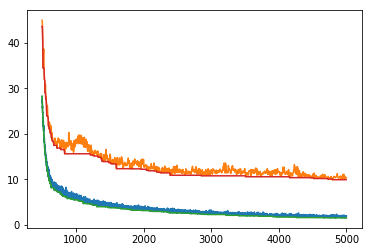

In [8]:
import matplotlib.pyplot as plt

train_df['loss'].loc[500:].plot()
test_df['loss'].loc[500:].plot()
train_df['min loss'].loc[500:].plot()
test_df['min loss'].loc[500:].plot()
print(test_df['min loss'].iloc[-1])

plt.show()

In [9]:
predictions = results[-1].ravel()[test_idx]
actual = dataset[2].ravel()[test_idx]

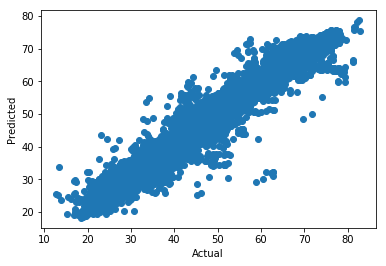

Max error:  31.96836334612675


In [10]:
plt.scatter(actual, predictions); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.show()
print('Max error: ', np.max(np.abs(actual - predictions)))

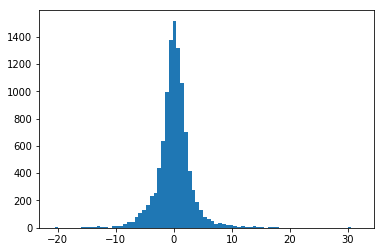

In [11]:
plt.hist(actual - predictions, bins = 80); plt.show()

In [12]:
len(predictions)

501

In [ ]:
import sklearn

sklearn.metrics.r2_score(predictions, actual)

In [ ]:
np.corrcoef(predictions, actual)